# Kiva Crowd-Funding Data Analysis

In [10]:
from narcos.kiva_data import KivaData
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', 
    {
        'grid.color': '.8',
        'labelsize': 'large',
    })
sns.set(font_scale = 1.3)
kiva_data = KivaData(use_sample=True)
df = kiva_data.loan_data

### Wordcloud

In [70]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import os

stopwords = set(STOPWORDS)
stopwords.add("user_favorite")

def plot_wordcloud(df, column, gender=None):
    if gender is None:
        text = ', '.join([t for t in df[column] if isinstance(t, str)])
        title = column.capitalize() + ' (All Genders)'
    else:
        text = ', '.join([t for t in df[df.gender==gender][column] if isinstance(t, str)])
        title = column.capitalize() + f' ({gender})'
    
    mask = np.array(
        Image.open(
            os.path.join(
                'image',
                f'{gender}.png' if gender else 'earth.png')))
    
    wordcloud = WordCloud(
        background_color='white',
        #max_words=200,
        max_font_size=25,
        mask=mask
    ).generate(text)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=30)
    plt.axis("off")
    
def plot_all_and_genders_wordcloud(df, column):
    figure = plt.figure(figsize=(20, 16))

    plt.subplot2grid((2, 2), (0, 0), colspan=2)
    plot_wordcloud(df, column)

    plt.subplot2grid((2, 2), (1, 0))
    plot_wordcloud(df, column, gender='male')

    plt.subplot2grid((2, 2), (1, 1))
    plot_wordcloud(df, column, gender='female')
    plt.savefig(os.path.join('image', f'kiva_data_map_{column}.png'))
    plt.show()

def draw_wordcloud(df):
    for column in ['tags', 'activity', 'use']:
        plot_all_and_genders_wordcloud(df, column)

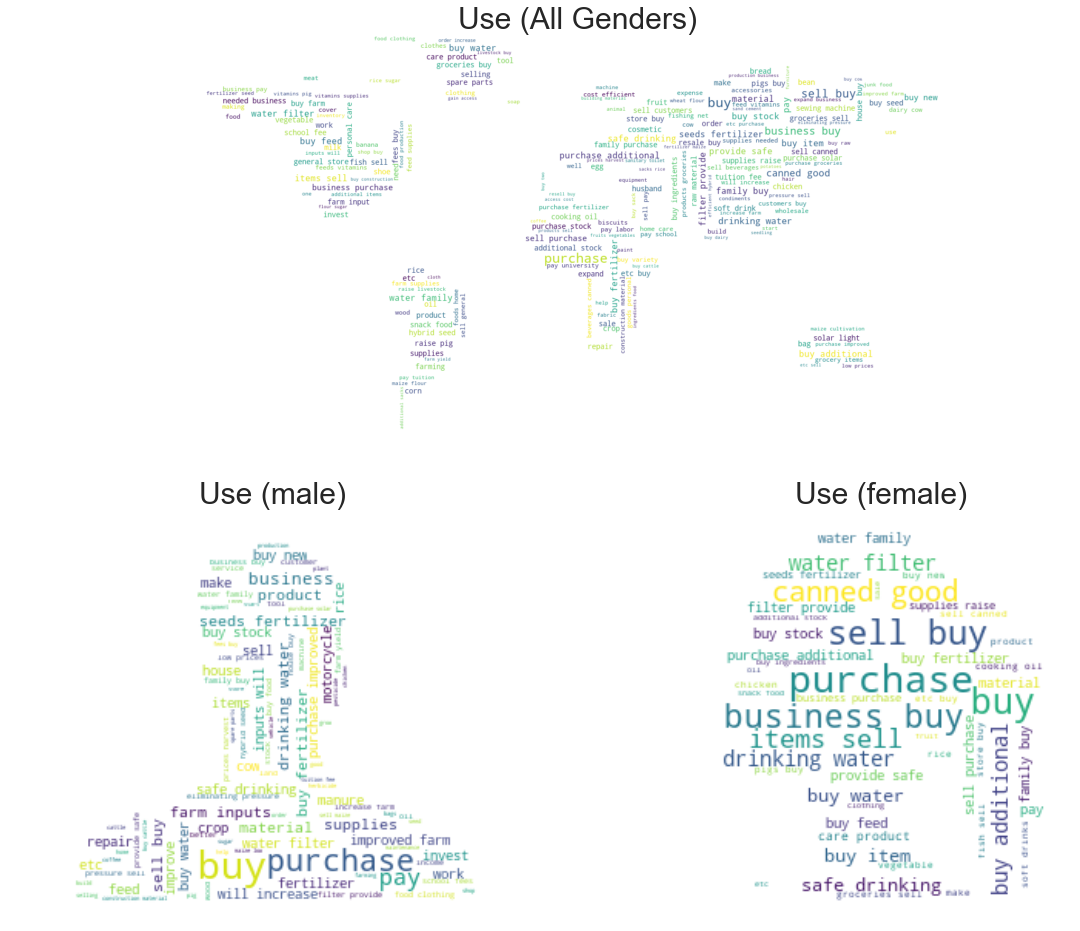

In [71]:
plot_all_and_genders_wordcloud(df, 'use')

## Histogram

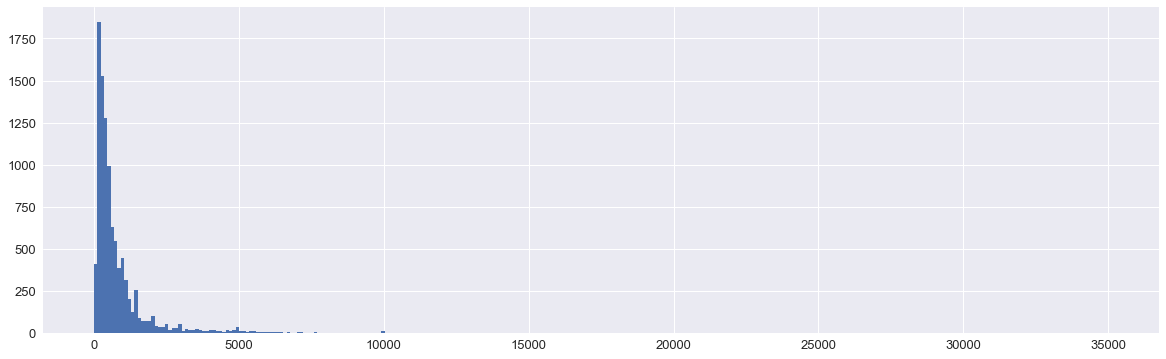

In [11]:
figure, ax = plt.subplots(figsize=(20,6))
df.reset_index()['funded_amount'].hist(
    bins=300,
    ax=ax
)
plt.show()

## Boxplot

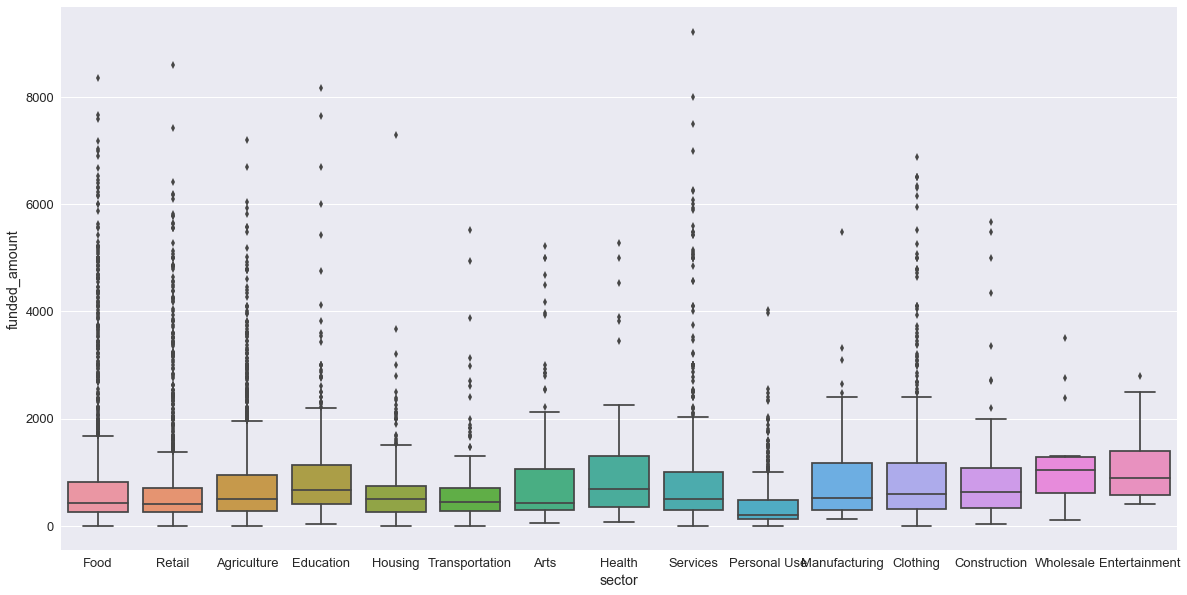

In [12]:
figure, ax = plt.subplots(figsize=(20,10))

sns.boxplot(
    x='sector', 
    y='funded_amount',
    #orient="h",
    data=df[df['funded_amount'] < 10000])
plt.show()

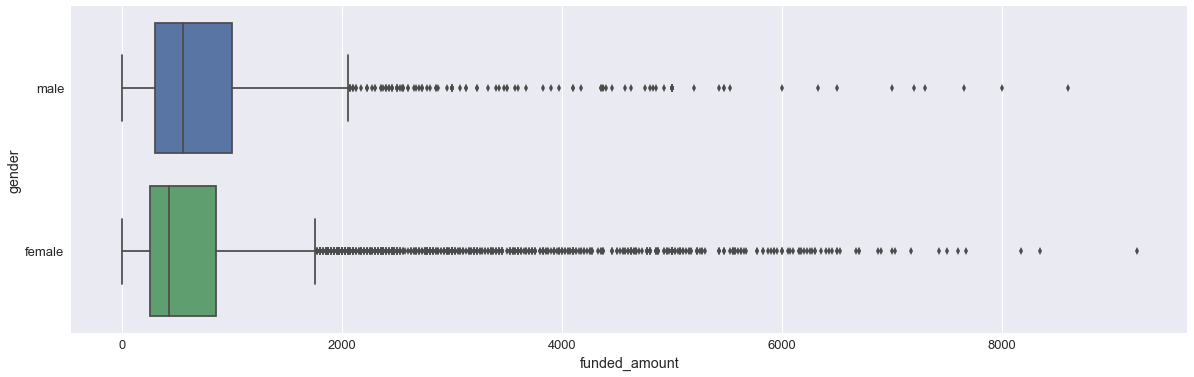

In [13]:
figure, ax = plt.subplots(figsize=(20,6))

sns.boxplot(
    y='gender', 
    x='funded_amount', 
    orient='h',
    data=df[df['funded_amount'] < 10000])
plt.show()

## Voilin Plot

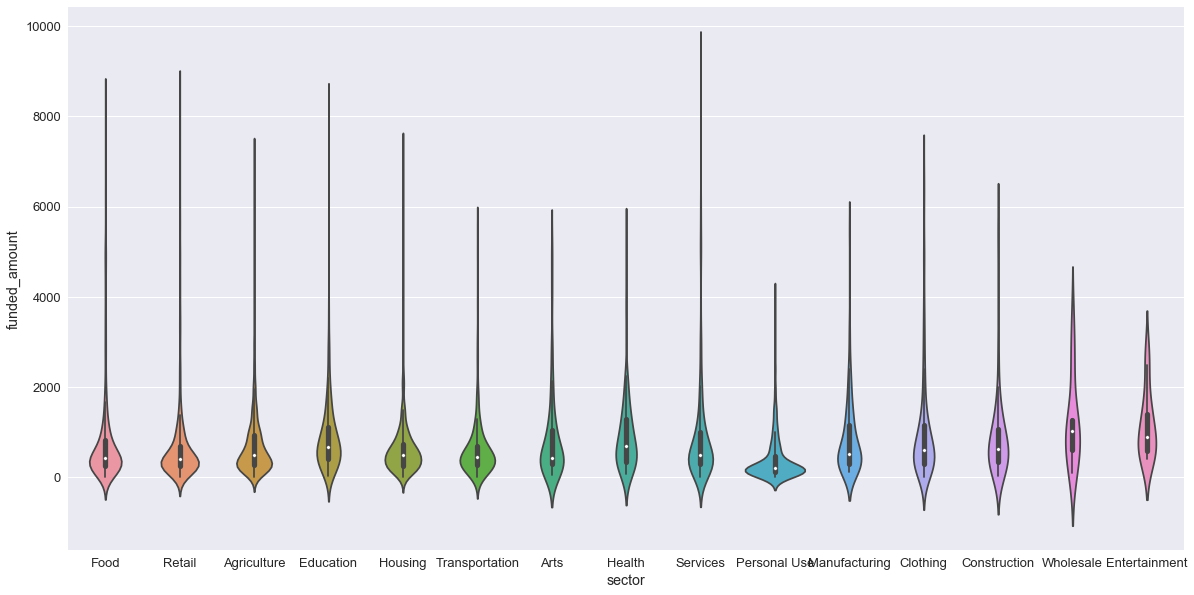

In [14]:
figure, ax = plt.subplots(figsize=(20,10))

sns.violinplot(
    x='sector',
    y='funded_amount',
    data=df[df['funded_amount'] < 10000]
)
plt.show()

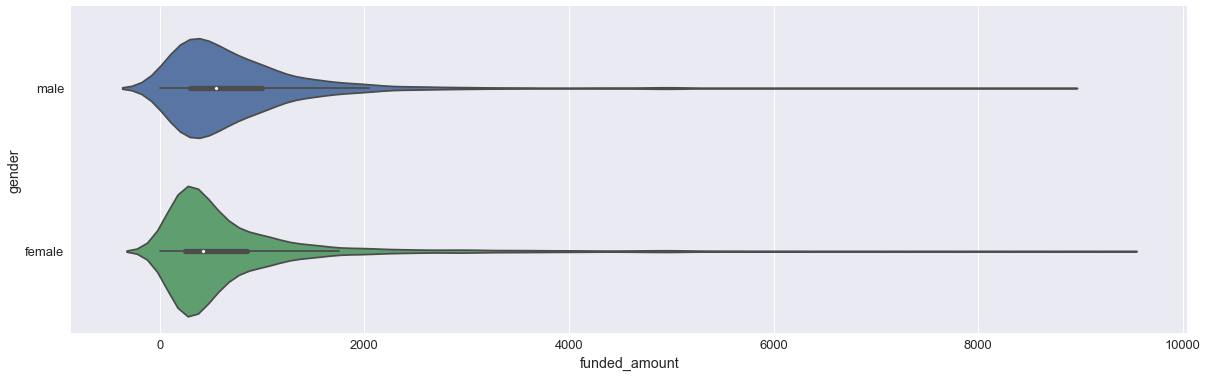

In [15]:
figure, ax = plt.subplots(figsize=(20,6))

sns.violinplot(
    y='gender', 
    x='funded_amount', 
    orient='h',
    data=df[df['funded_amount'] < 10000])
plt.show()

## Number loans ranked by country

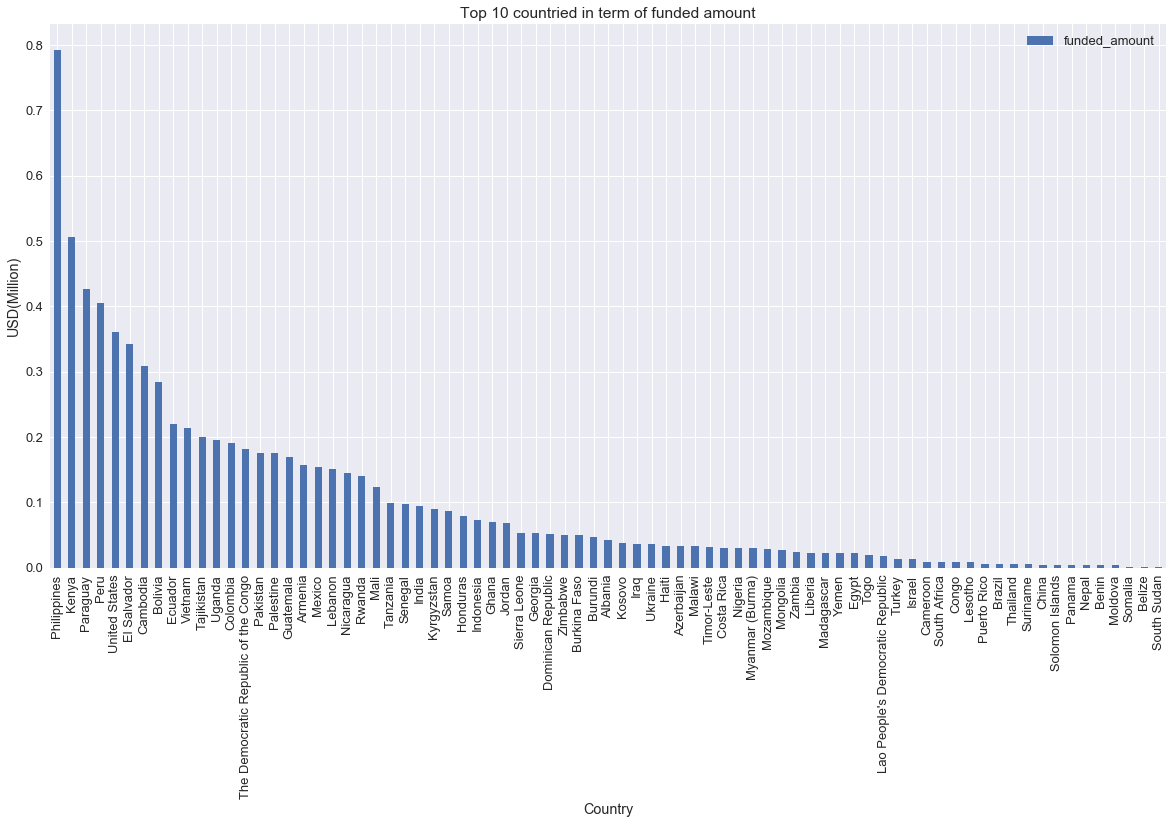

In [74]:
figure, ax = plt.subplots(figsize=(20,10))
( df.groupby('country')[['funded_amount']].sum() / (1000 * 1000 ) ).sort_values(
    by='funded_amount', ascending=False).plot.bar(
    ax=ax,
)
plt.xlabel('Country')
plt.ylabel('USD(Million)')
plt.title('Top 10 countried in term of funded amount')
plt.show()

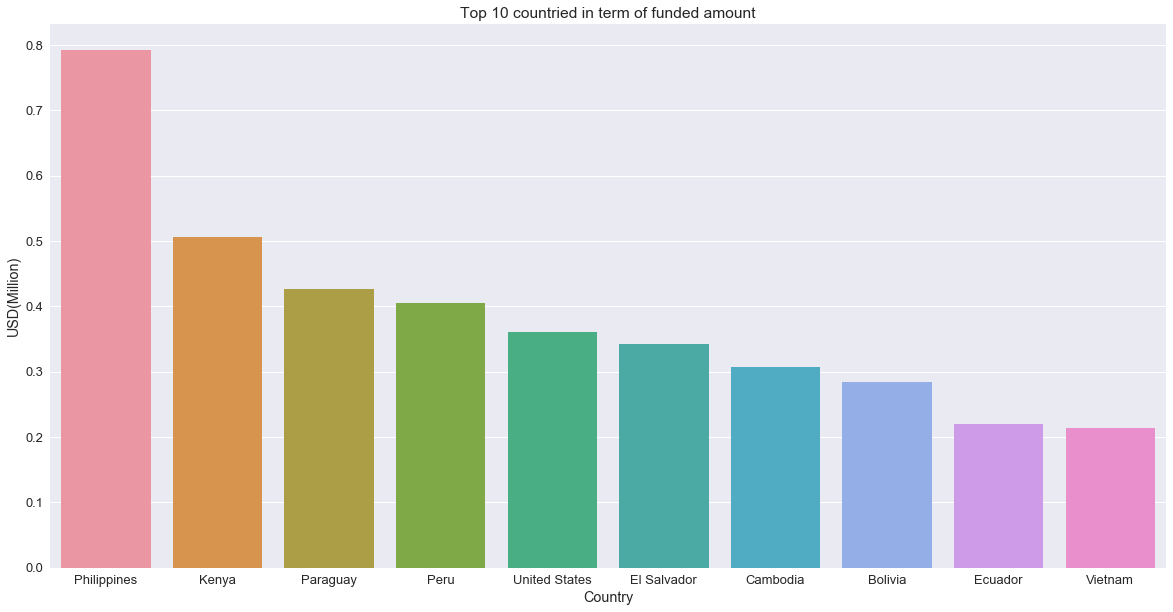

In [82]:
figure, ax = plt.subplots(figsize=(20,10))
sns.barplot(
    data= (df.groupby(
        'country'
    )[['funded_amount']].sum() / (1000 * 1000 )).sort_values(
        by='funded_amount', ascending=False).head(10).reset_index(),
    x='country',
    y='funded_amount',
    ax=ax,
)
plt.xlabel('Country')
plt.ylabel('USD(Million)')
plt.title('Top 10 countried in term of funded amount')
plt.show()

In [89]:
(df.groupby(
       ['country', 'gender']
    )[['funded_amount']].sum() / (1000 * 1000 )).sort_values(
        by='funded_amount', ascending=False).head(10).reset_index()

,country,gender,funded_amount
0,Philippines,female,0.731475
1,Paraguay,female,0.388825
2,Kenya,female,0.372180
3,Peru,female,0.315125
4,Cambodia,female,0.264375
5,Bolivia,female,0.216825
6,Vietnam,female,0.209350
7,United States,female,0.198860
8,El Salvador,female,0.191050
9,Ecuador,female,0.182200


## Stacked Bar showing How Loan Distributed Amount Genders per Country

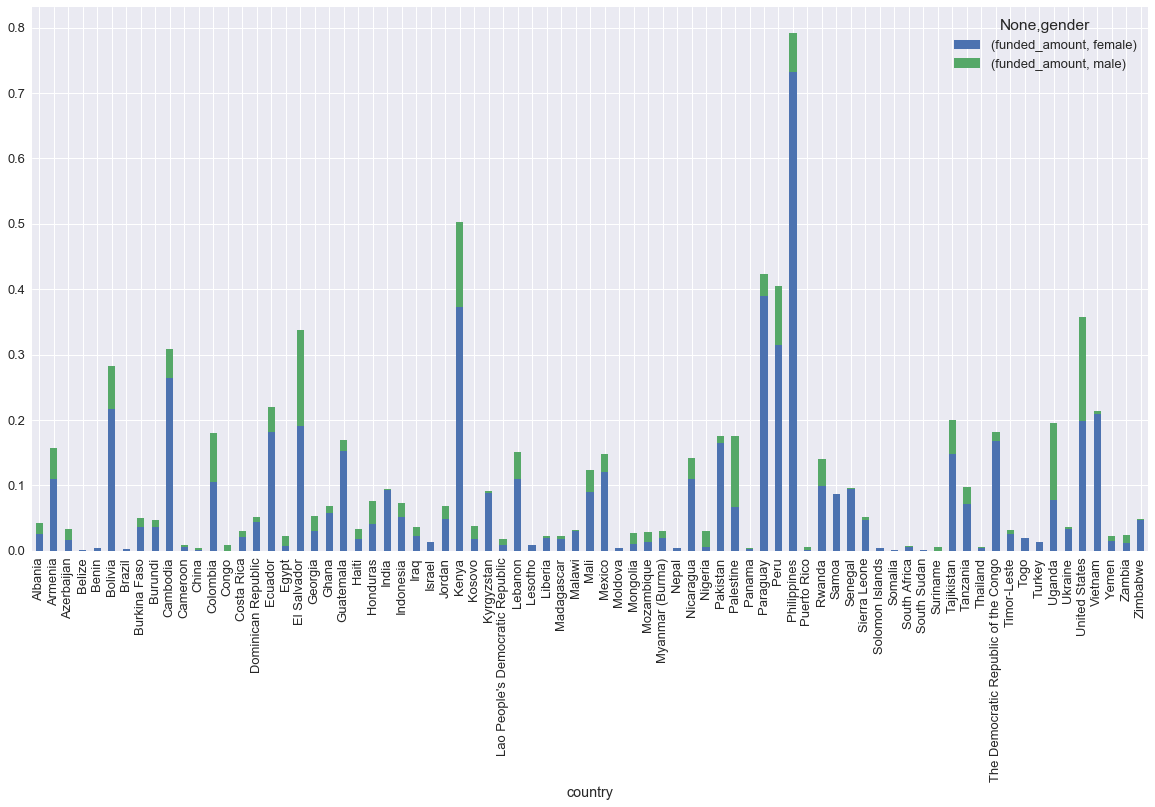

In [111]:
figure, ax = plt.subplots(figsize=(20,10))
(df.groupby(
       ['country', 'gender']
    )[['funded_amount']].sum() / (1000 * 1000 )).reset_index().pivot(
    index='country', columns='gender'
).plot.bar(
    stacked=True,
    ax=ax
)
plt.show()

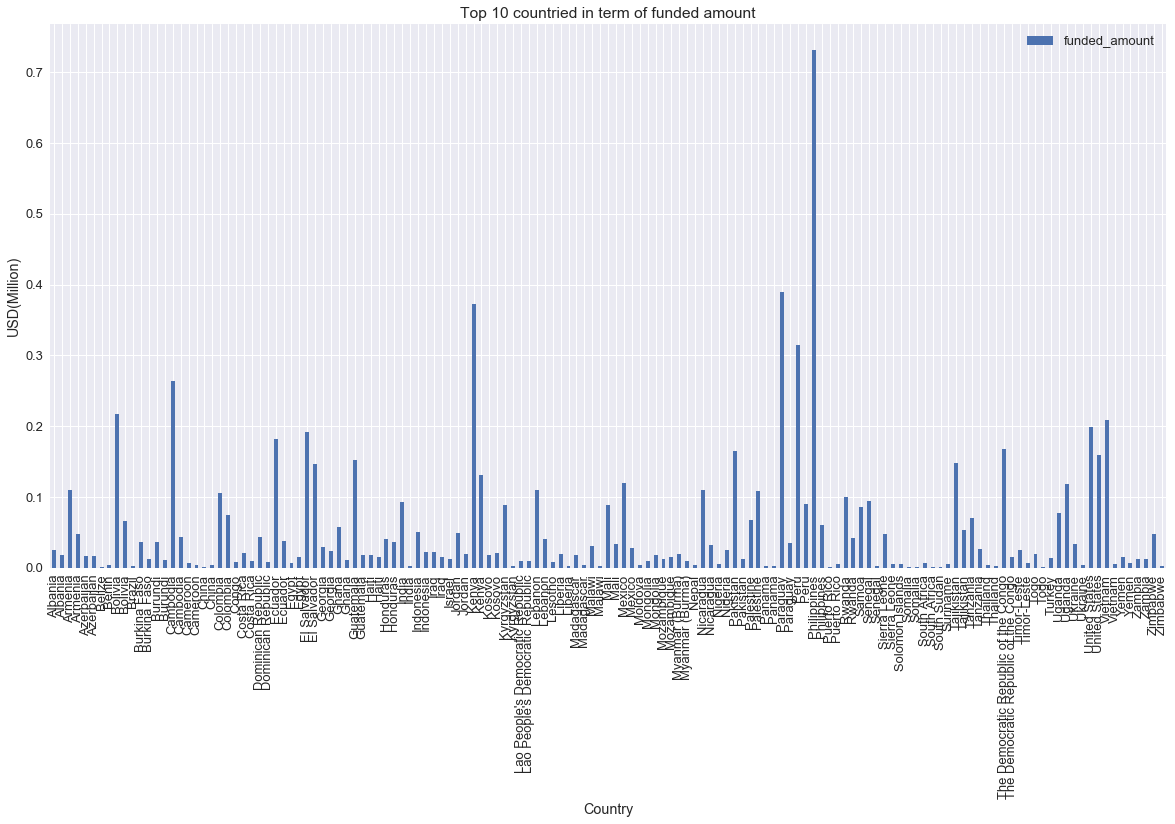

In [102]:
figure, ax = plt.subplots(figsize=(20,10))
(df.groupby(
       ['country', 'gender']
    )[['funded_amount']].sum() / (1000 * 1000 )).reset_index().plot(
    kind='bar',
    ax=ax,
    x='country',
    y='funded_amount',
    #stack=True
)
plt.xlabel('Country')
plt.ylabel('USD(Million)')
plt.title('Top 10 countried in term of funded amount')
plt.show()

In [76]:
## Median Loan Amount Ranking

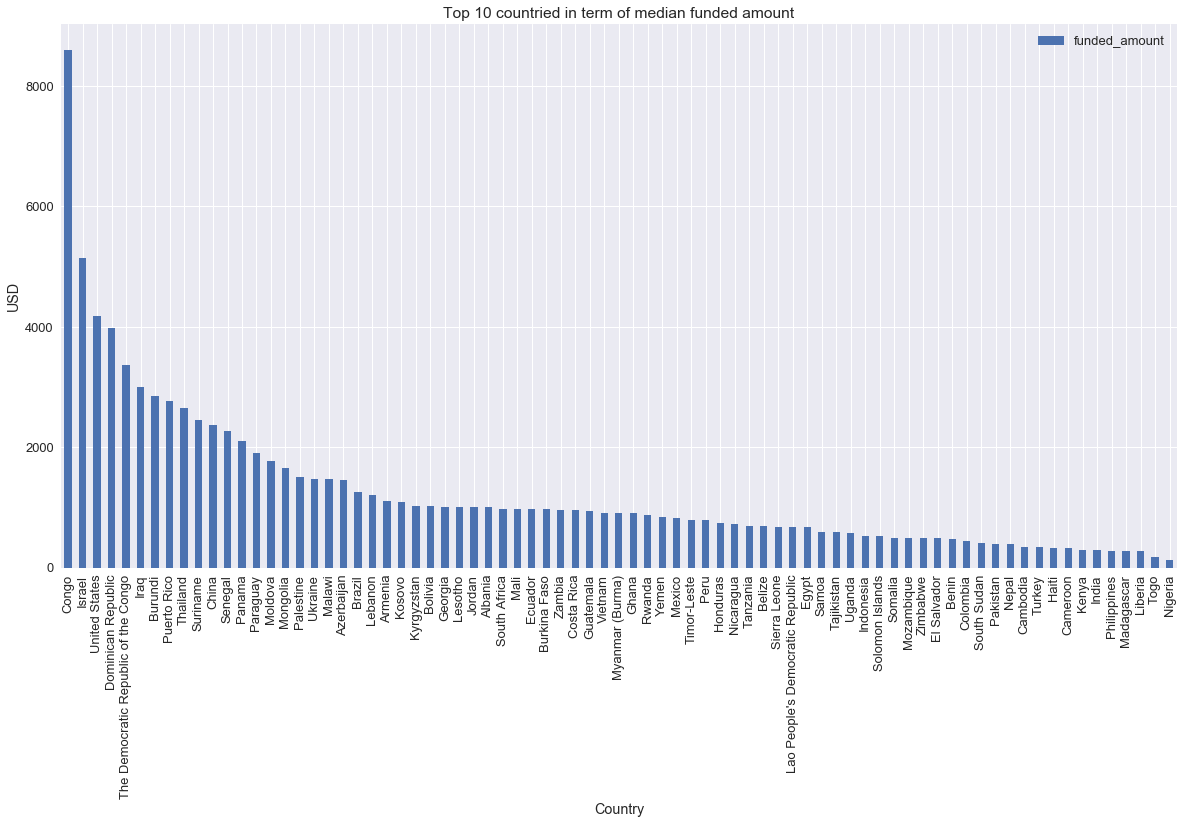

In [75]:
figure, ax = plt.subplots(figsize=(20,10))
( df.groupby('country')[['funded_amount']].median() ).sort_values(
    by='funded_amount', ascending=False).plot.bar(
    ax=ax,
)
plt.xlabel('Country')
plt.ylabel('USD')
plt.title('Top 10 countried in term of median funded amount')
plt.show()

## GDP vs Median Funded Amount

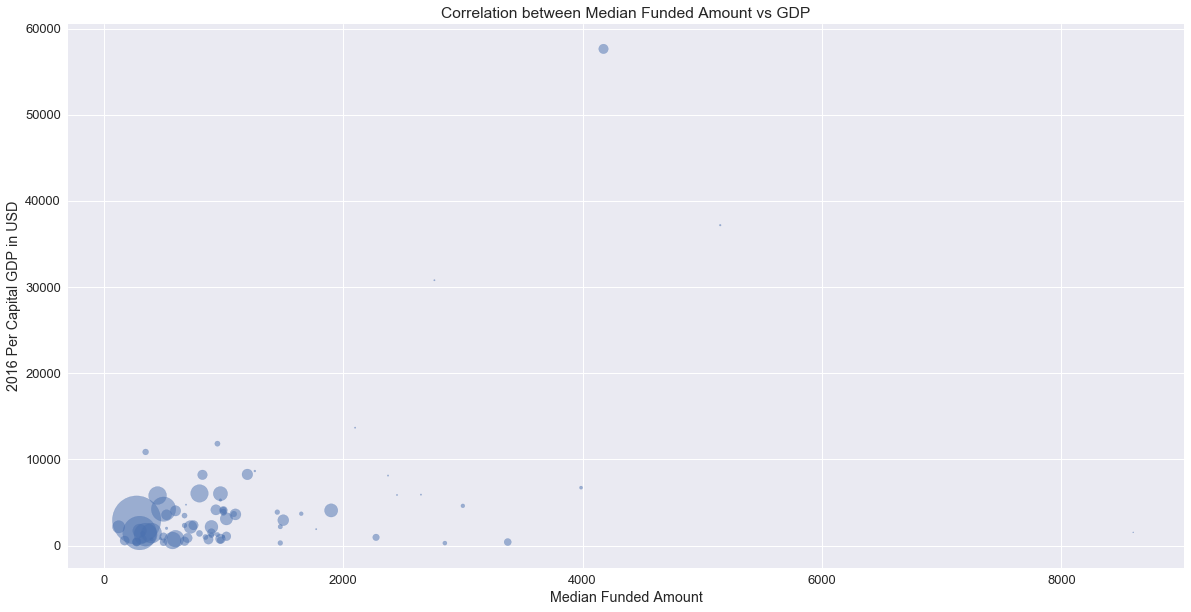

In [19]:
import wbdata
import numpy as np
import pandas as pd
gdp_lookup = {}
for country_code in df.country_code.unique():
    gdp_lookup[country_code] = wbdata.get_data("NY.GDP.PCAP.CD", country=(country_code))[1]['value']

median_by_country = df.groupby('country_code')[['funded_amount']].median()
median_by_country
for country_code in median_by_country.index:
    median_by_country.loc[country_code, 'gdp'] = pd.to_numeric(gdp_lookup[country_code])

count_by_country = df.groupby('country_code')[['funded_amount']].count().rename(
    columns={'funded_amount': 'loan_count'}
)
median_by_country = median_by_country.join(count_by_country)

figure, ax = plt.subplots(figsize=(20,10))
median_by_country.plot.scatter(
    x='funded_amount',
    y = 'gdp',
    s = median_by_country['loan_count'],
    ax=ax,
    alpha=0.5,
)

plt.xlabel('Median Funded Amount')
plt.ylabel('2016 Per Capital GDP in USD')
plt.title('Correlation between Median Funded Amount vs GDP')
plt.show()

### Narrow down to GDP < 20000, and Median Funded Amount < 4000

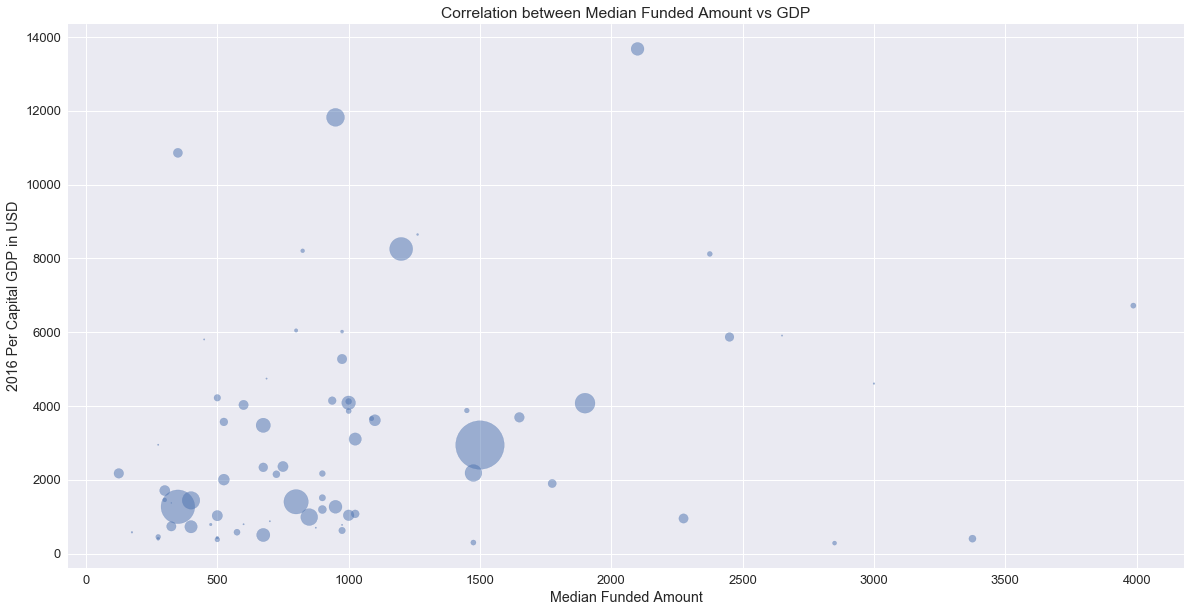

In [20]:
figure, ax = plt.subplots(figsize=(20,10))
median_by_country.query(
    'gdp < 20000 & funded_amount < 4000'
).plot.scatter(
    x='funded_amount',
    y = 'gdp',
    s = median_by_country['loan_count'],
    ax=ax,
    alpha=0.5,
)

plt.xlabel('Median Funded Amount')
plt.ylabel('2016 Per Capital GDP in USD')
plt.title('Correlation between Median Funded Amount vs GDP')
plt.show()

## Gender

In [21]:

median_by_country = df.groupby(['country_code', 'gender'])[['funded_amount']].median().reset_index()

median_by_country.loc[:, 'gdp'] = median_by_country['country_code'].map(
    lambda x: pd.to_numeric(gdp_lookup[x])
)

In [22]:
median_by_country = median_by_country.set_index(['country_code', 'gender'])


In [23]:
count_by_country = df.groupby(['country_code', 'gender'])[['funded_amount']].count().rename(
    columns={'funded_amount': 'loan_count'}
)
median_by_country = median_by_country.join(count_by_country).reset_index()

In [24]:
median_by_country.head()

,country_code,gender,funded_amount,gdp,loan_count
0,AL,female,1000.0,4124.982390,21
1,AL,male,1000.0,4124.982390,14
2,AM,female,1425.0,3614.688357,77
3,AM,male,850.0,3614.688357,47
4,AZ,female,1600.0,3878.709257,10


In [25]:
median_by_country[
    median_by_country['gender'] == 'male'
].head()

,country_code,gender,funded_amount,gdp,loan_count
1,AL,male,1000.0,4124.982390,14
3,AM,male,850.0,3614.688357,47
5,AZ,male,1250.0,3878.709257,13
7,BF,male,975.0,627.103079,13
9,BI,male,3125.0,285.727442,4


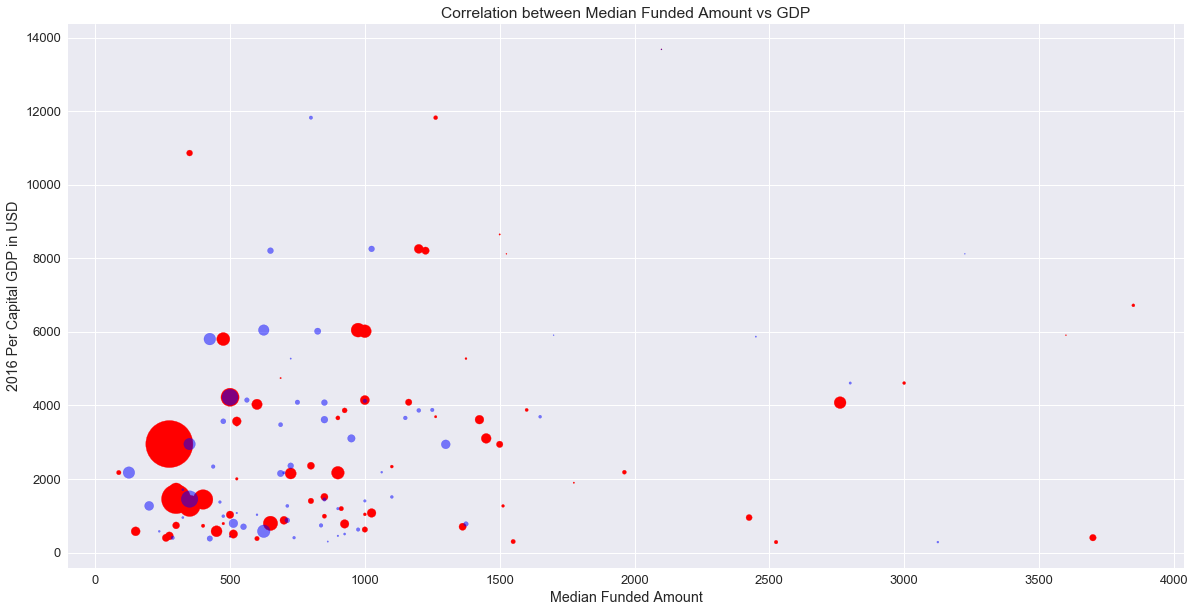

In [28]:
figure, ax = plt.subplots(figsize=(20,10))

median_by_country = median_by_country.query('gdp < 20000 & funded_amount < 4000')
female_df = median_by_country[
    median_by_country['gender'] == 'female'
]

female_df.plot.scatter(
    x='funded_amount',
    y='gdp',
    color='red',
    s = female_df['loan_count'],
    ax=ax
)

male_df = median_by_country[
    median_by_country['gender'] == 'male'
]

male_df.plot.scatter(
    x='funded_amount',
    y='gdp',
    color='blue',
    s = male_df['loan_count'],
    ax=ax,
    alpha=0.5
)

plt.xlabel('Median Funded Amount')
plt.ylabel('2016 Per Capital GDP in USD')
plt.title('Correlation between Median Funded Amount vs GDP')
plt.show()

### Narrow down to GDP < 20000, and Median Funded Amount < 4000

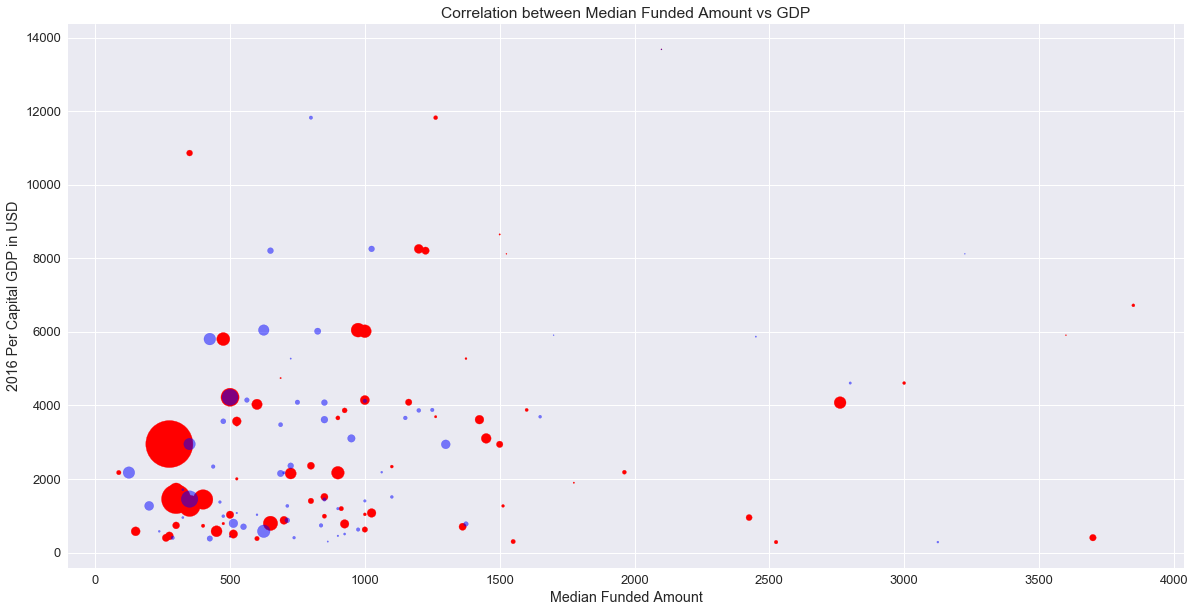

In [29]:
figure, ax = plt.subplots(figsize=(20,10))

female_df = median_by_country[
    median_by_country['gender'] == 'female'
]

female_df.plot.scatter(
    x='funded_amount',
    y='gdp',
    color='red',
    s = female_df['loan_count'],
    ax=ax
)

male_df = median_by_country[
    median_by_country['gender'] == 'male'
]

male_df.plot.scatter(
    x='funded_amount',
    y='gdp',
    color='blue',
    s = male_df['loan_count'],
    ax=ax,
    alpha=0.5
)

plt.xlabel('Median Funded Amount')
plt.ylabel('2016 Per Capital GDP in USD')
plt.title('Correlation between Median Funded Amount vs GDP')
plt.show()